In [1]:
import pandas as pd
#option pour imprimer toutes les colonnes
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import numpy as np

In [2]:
client=pd.read_csv("C:\\Users\\DIALLBA\\Desktop\\Cours Data Science\\Session 6\\vispremv.dat",sep=" ")

In [3]:
#Restriction des donneees non transformées
client2=client[['SEXEQ', 'FAMIQ', 'PCSPQ', 'RELAT', 'AGER', 'OPGNBL',
       'MOYRVL', 'TAVEPL', 'ENDETL', 'GAGETL', 'GAGECL', 'GAGEML', 'KVUNB',
       'QSMOY', 'QCREDL', 'DMVTPL', 'BOPPNL', 'FACANL', 'LGAGTL', 'VIENB',
       'VIEMTL', 'UEMNB', 'XLGNB', 'XLGMTL', 'YLVNB', 'YLVMTL', 'ROCNB',
       'NPTAG', 'ITAVCL', 'HAVEFL', 'JNBJDL', 'CARVP']]

In [4]:
#recodification

client2.SEXEQ=client2.SEXEQ.replace(({"Shom":1, "Sfem":0}))
client2.FAMIQ=client2.FAMIQ.replace(({"Fcou":1, "Fseu":0}))
client2=pd.concat((client2,pd.get_dummies(client2["PCSPQ"])),axis=1)                  
client2.loc[:,"CARVP"] = client2.loc[:,"CARVP"].replace({"Coui":1, "Cnon":0})
client2.drop(columns="PCSPQ",inplace=True)

C:\Users\DIALLBA\AppData\Roaming\Python\Python38\site-packages\pandas\core\generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


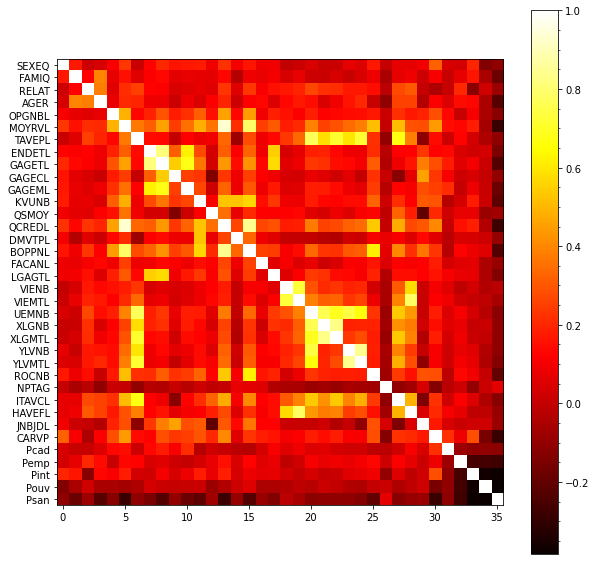

In [5]:
#correlation

fig, ax1 = plt.subplots(figsize=(10,10))
im = ax1.imshow(client2.corr(), cmap='hot', interpolation='nearest')
cbar = fig.colorbar(im, ax=ax1);cbar.minorticks_on()#, ax=ax1)
plt.yticks(range(0,36),client2.columns)
plt.show()

In [6]:
#moyenne variable cible
client2.CARVP.mean()

0.33584195672624645

In [19]:
#standardisation
from sklearn.preprocessing import StandardScaler
X_orig=client2.drop(columns="CARVP")
X_ori=client2.drop(columns="CARVP")
scaler = StandardScaler()
scaler.fit(X_ori)
X_ori = scaler.transform(X_ori)
Y_ori=client2.loc[:,"CARVP"]

In [8]:
from sklearn.model_selection import train_test_split
X_ori_train,X_ori_test,Y_ori_train,Y_ori_test=train_test_split(X_ori,Y_ori,test_size=0.25,random_state=42)

### Regression logistique

In [9]:
from sklearn.linear_model import LogisticRegression
LR=LogisticRegression(penalty="l2",C=0.1)
modele= LR.fit(X_ori_train,Y_ori_train)
modele.predict(X_ori_test)
print(modele.score(X_ori_train,Y_ori_train), modele.score(X_ori_test,Y_ori_test))

0.8582183186951067 0.8082706766917294


In [10]:
#GridSearch
from sklearn.model_selection import GridSearchCV
parameters = {'C':[0.1, 0.2, 0.5, 1.0, 2.0]}
modele_grid = GridSearchCV(modele, parameters,n_jobs=-1, cv=5)
modele_grid.fit(X_ori_train, Y_ori_train)
modele_grid.score(X_ori_test, Y_ori_test)

modele_grid.best_params_

{'C': 0.2}

In [11]:
LR_b=LogisticRegression(C=0.2)
modeleb= LR.fit(X_ori_train,Y_ori_train)
modeleb.predict(X_ori_test)

print(modeleb.score(X_ori_train, Y_ori_train),modeleb.score(X_ori_test, Y_ori_test))

0.8582183186951067 0.8082706766917294


### Gradient Boosting

In [16]:
def fitScore(pipe, ori=False, gs=False, param=None, ver=False):
    if ver:
        print("Parameters list:\n",pipe.get_params().keys())
    if gs:
        pipe = GridSearchCV(pipe, param, cv=5)
    if ori:
        pipe.fit(X_ori_train,Y_ori_train)
        print(pipe.score(X_ori_train,Y_ori_train), pipe.score(X_ori_test,Y_ori_test))
    else:
        pipe.fit(X_pca_tr,y_pca_tr)
        print(pipe.score(X_pca_train,y_pca_train), pipe.score(X_pca_test,y_pca_test))
    if gs:
        print("Best parameters (CV score=%0.3f)"%pipe.best_score_,"\n",pipe.best_params_)
    return pipe

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
pipe = GradientBoostingClassifier(n_estimators=550, learning_rate=0.08, max_depth=1, random_state=42)
parameters={"n_estimators":[550],"learning_rate":[0.08]}
pipe = fitScore(pipe, ori=True, gs=False, param=parameters, ver=False)

0.9523212045169385 0.924812030075188


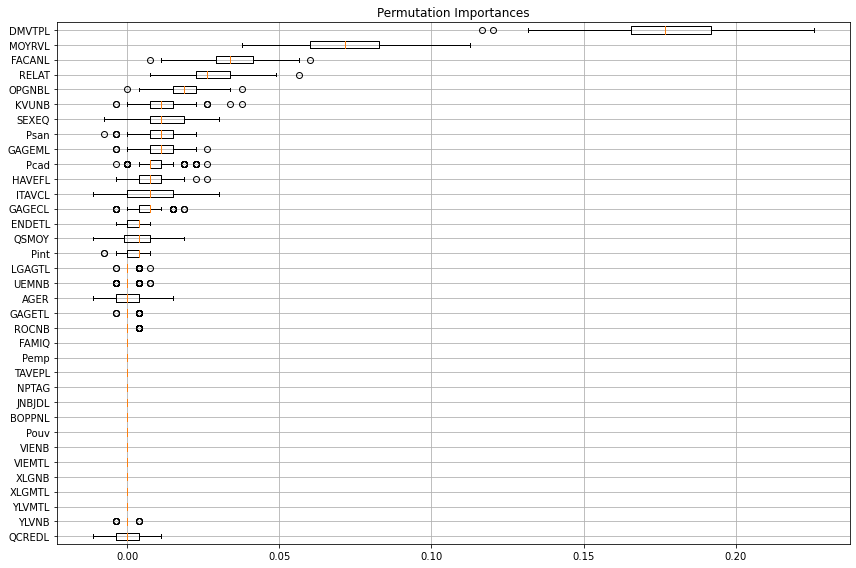

In [21]:
#Visualize the feature importance
from sklearn.inspection import permutation_importance
importance = pd.Series( pipe.feature_importances_, index=X_orig.columns).sort_values()
#importance.plot(kind='barh',figsize=(8,6), grid=True)
result = permutation_importance( pipe, X_ori_test, Y_ori_test, n_repeats=200, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(12,8))
ax.boxplot( result.importances[sorted_idx].T, vert=False, labels=X_orig.columns[sorted_idx])
ax.set_title("Permutation Importances");fig.tight_layout(); plt.grid(); plt.show()

### XGboost

In [22]:
import xgboost as xgb
mod_Xgboost=xgb.XGBClassifier() 
mod_Xgboost.fit(X_ori_train, Y_ori_train)
print (mod_Xgboost.score(X_ori_train, Y_ori_train),mod_Xgboost.score(X_ori_test, Y_ori_test))

1.0 0.9022556390977443


### KNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_ori_train,Y_ori_train)
neigh.predict(X_ori_test)
neigh.score(X_ori_test,Y_ori_test)

0.6954887218045113

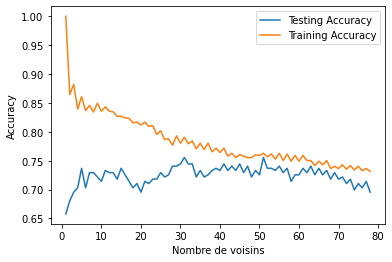

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
neighbors = np.arange(1, 79)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_ori_train, Y_ori_train)   
    train_accuracy[i] = knn.score(X_ori_train, Y_ori_train)   
    test_accuracy[i] = knn.score(X_ori_test, Y_ori_test)
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Nombre de voisins')
plt.ylabel('Accuracy')
plt.show()

### Resultat

In [25]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


 knn
0.7233762254901961
Classif Report:
               precision    recall  f1-score   support

           0       0.73      0.82      0.78       170
           1       0.60      0.47      0.53        96

    accuracy                           0.70       266
   macro avg       0.67      0.65      0.65       266
weighted avg       0.68      0.70      0.69       266

Confus matrix:
 [[140  30]
 [ 51  45]]

 LR
0.877267156862745
Classif Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       170
           1       0.76      0.68      0.72        96

    accuracy                           0.81       266
   macro avg       0.80      0.78      0.79       266
weighted avg       0.81      0.81      0.81       266

Confus matrix:
 [[150  20]
 [ 31  65]]

 Xgboost
0.9731617647058823
Classif Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.92       170
           1       0.88      0.

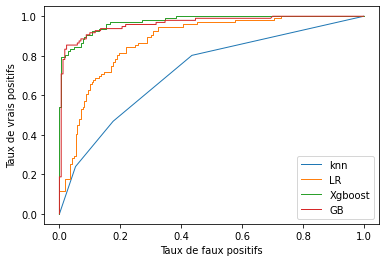

le F1 score du modèle knn est : 0.5263157894736842
le F1 score du modèle LR est : 0.7182320441988951
le F1 score du modèle Xgboost est : 0.8617021276595744
le F1 score du modèle GB est : 0.8913043478260869


In [31]:
#Courbe roc et F1score
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.metrics import f1_score

listMethod=[["knn",neigh],["LR",LR],["Xgboost",mod_Xgboost],["GB",pipe]]
# Tracé des courbes
for method in enumerate(listMethod):
    probas_ = method[1][1].predict_proba(X_ori_test)
    fpr, tpr, thresholds = roc_curve(Y_ori_test, probas_[:,1])
    print ("\n",method[1][0])   
    print(metrics.auc(fpr,tpr))
    y_pred = method[1][1].predict(X_ori_test)
    print("Classif Report:\n",classification_report(Y_ori_test, y_pred))
    print("Confus matrix:\n",confusion_matrix(Y_ori_test, y_pred))
    plt.plot(fpr, tpr, lw=1,label="%s"%method[1][0])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.legend(loc="best")
plt.show()

print ("le F1 score du modèle knn est :",f1_score(Y_ori_test,neigh.predict(X_ori_test),zero_division=1))
print ("le F1 score du modèle LR est :",f1_score(Y_ori_test,LR.predict(X_ori_test),zero_division=1))
print ("le F1 score du modèle Xgboost est :",f1_score(Y_ori_test,mod_Xgboost.predict(X_ori_test),zero_division=1))
print ("le F1 score du modèle GB est :",f1_score(Y_ori_test,pipe.predict(X_ori_test),zero_division=1))
